In [1]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0,"
from pathlib import Path
import json, shutil, random
from tqdm import tqdm
from datetime import datetime
from omegaconf import OmegaConf
from einops import rearrange
import numpy as np
import matplotlib.pyplot as plt
import lovely_tensors as lt
from PIL import Image, ImageDraw
import torch
lt.monkey_patch()

sys.path.append("../../src")
from musubi_tuner.fpack_1fmc_generate import FramePack_1fmc
from musubi_tuner.frame_pack.hunyuan_video_packed import attn_cache
from musubi_tuner.utils.preproc_utils import getres, get_info_from_vistorybench, parse_bodylayout
from musubi_tuner.utils.viz_utils import convert_result_to_df_wpose, annot_viz, draw_final_img
from musubi_tuner.utils.attn_utils import get_img_attn_map

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.
INFO:root:Xformers is installed!
INFO:root:Flash Attn is installed!
INFO:root:Sage Attn is installed!


Trying to import sageattention
Successfully imported sageattention
model_path is /lustre/fs1/home/yo564250/workspace/whisperer/main/models/musubi-tuner/src/practice/../../src/musubi_tuner/ckpts/hr16/yolox-onnx/yolox_l.torchscript.pt
model_path is /lustre/fs1/home/yo564250/workspace/whisperer/main/models/musubi-tuner/src/practice/../../src/musubi_tuner/ckpts/hr16/DWPose-TorchScript-BatchSize5/dw-ll_ucoco_384_bs5.torchscript.pt

DWPose: Using yolox_l.torchscript.pt for bbox detection and dw-ll_ucoco_384_bs5.torchscript.pt for pose estimation
DWPose: Caching TorchScript module yolox_l.torchscript.pt on ...
DWPose: Caching TorchScript module dw-ll_ucoco_384_bs5.torchscript.pt on ...


/home/yo564250/conda-envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yo564250/conda-envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cuda:0


In [2]:
# framepack_model = FramePack_1fmc(
#     dit_path = "/projects/bffz/ykwon4/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors",
#     vae_path = "/projects/bffz/ykwon4/ComfyUI/models/vae/hunyuan-video-t2v-720p-vae.pt",
#     text_encoder1_path = "/projects/bffz/ykwon4/ComfyUI/models/text_encoders/llava_llama3_fp16.safetensors",
#     text_encoder2_path = "/projects/bffz/ykwon4/ComfyUI/models/text_encoders/clip_l.safetensors",
#     lora_path = "/work/nvme/bffz/ykwon4/musubi-training/idmask_control_lora_wrope_v3_2/test1-step00005000.safetensors"
# )
framepack_model = FramePack_1fmc(
    lora_path = "../../outputs/training/idmask_control_lora_wrope_v3/idmask_control_lora_wrope_v3_multi-1-step00005000.safetensors"
)

INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Creating HunyuanVideoTransformer3DModelPacked
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Image Projection: False
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loading DiT model from /lustre/fs1/home/yo564250/workspace/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, device=cuda:0
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loaded DiT model from /lustre/fs1/home/yo564250/workspace/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, info=_IncompatibleKeys(missing_keys=[], unexpected_keys=['image_projection.down.bias', 'image_projection.down.weight', 'image_projection.up.bias', 'image_projection.up.weight'])
INFO:musubi_tuner.wan_generate_video:Loading LoRA weights from ../../outputs/training/idmask_control_lora_wrope_v3/idmask_control_lora_wrope_v3_multi-1-step00005000.safetensors with multiplier 1.0
INFO:musubi_tuner.networks.lora:create LoRA network from weights
INFO:musubi_tuner.networks.

Model, VAE, Text Encoders, LoRA loaded.


### ViStoryBench

In [7]:
sys.path.append("/home/yo564250/workspace/whisperer/main/evaluations/vistorybench")
# sys.path.append("/projects/bffz/ykwon4/vistorybench/")
from vistorybench.data_process.dataset_process.dataset_load import StoryDataset
vistory_dataset_path = Path("/home/yo564250/workspace/whisperer/main/evaluations/vistorybench/datasets/ViStory")
# vistory_dataset_path = Path("/projects/bffz/ykwon4/vistorybench/data/dataset/ViStory")
vistory_dataset = StoryDataset(vistory_dataset_path)

story_num = '59'

story = vistory_dataset.load_story(story_num)
story_dict = {x['index']:x for x in story['shots']}
vanila_shot, vanila_character_shot, _ = get_info_from_vistorybench(vistory_dataset, story_num, 1)

# prev_output_path = Path("/groups/chenchen/patrick/ViStoryBench/outputs/whisperer/v3_multi_step5000_1107layout/en/20251108_230808")
# shutil.copytree(prev_output_path / story_num, f"tmp/{story_num}", dirs_exist_ok=True)

In [8]:
main_layout_path = Path("/groups/chenchen/patrick/ViStoryBench/gen_layouts_bulk/20251107_132846_v2")
# main_layout_path = Path("/projects/bffz/ykwon4/vistorybench/data/gen_layouts_bulk/20250927_101053")
# main_layout_path = Path("/projects/bffz/ykwon4/vistorybench/data/gen_layouts_bulk/20251107_132846_v2")
shot_num = 11
story_shot, characters_shot, prompt = get_info_from_vistorybench(vistory_dataset, story_num, shot_num)
prompt = ";".join(prompt.split(";")[2:4])
# prompt = "Bella sits curled up on the grass, staring to the left, her chin resting on her knees, her hair tousled by the breeze;Daytime, grassy field, bright sunshine, blue sky with white clouds"

layouts = [
    (x.stem, list(map(int, x.stem.split("-pages_")[-1].split("_")))) 
    for x in  list(main_layout_path.glob(f"story_{story_num}*"))]
layout_name = [(x[0], x[1][0]) for x in layouts if shot_num in range(x[1][0], x[1][1]+1)][0]
author_output_dir = main_layout_path / layout_name[0]
layout = parse_bodylayout(author_output_dir / "pose_layout.json")
panel_bbox, panel_layout = layout[f'[PANEL-{shot_num-layout_name[1]+1}]']
panel_width, panel_height = (panel_bbox[2]-panel_bbox[0])/1000*768, (panel_bbox[3]-panel_bbox[1])/1000*1024
width, height = getres(panel_width, panel_height, target_area=1344*768, max_aspect_ratio=2.5)
# characters_shot = {'David' : {'images' : ['David.png']}}
# characters_shot = vanila_character_shot
panel_layout = {0: {'bbox' : [0.14, 0.131, 0.5, 0.908], 'body': []}, 1: {'bbox' : [0.6, 0.131, 0.9, 0.908], 'body': []}}

print(prompt)
print("\n".join([f"{k} : {v['images']}" for k, v in characters_shot.items()]))
print((width, height))
print([v['bbox'] for _, v in panel_layout.items()])

Bryce hides on top of the wardrobe, looking nervous. Juli and Lynette search the room, Juli excited and Lynette mischievous. Neither notices Bryce.;Daytime, Bryce’s bedroom. The room is slightly messy, with the wardrobe door ajar and boxes under the bed. The atmosphere is tense.
Bryce : ['/home/yo564250/workspace/whisperer/main/evaluations/vistorybench/datasets/ViStory/59/image/Bryce/00.jpg']
Julianna (Juli) : ['/home/yo564250/workspace/whisperer/main/evaluations/vistorybench/datasets/ViStory/59/image/Julianna (Juli)/00.jpg', '/home/yo564250/workspace/whisperer/main/evaluations/vistorybench/datasets/ViStory/59/image/Julianna (Juli)/01.jpg']
Lynette : ['/home/yo564250/workspace/whisperer/main/evaluations/vistorybench/datasets/ViStory/59/image/Lynette/00.jpg']
(1600, 640)
[[0.14, 0.131, 0.5, 0.908], [0.6, 0.131, 0.9, 0.908]]


In [ ]:
from musubi_tuner.utils.keypalign_utils import search_facebbox_for_layout

debug_dict = search_facebbox_for_layout(
    panel_layout, characters_shot, (width, height), 
    crop_face_detect=True, use_face_detect=True,
    c_width_given=256, scale_c=1.2, use_safety=True,
    bbox_mode='provided_size_mid_x', max_chara_imgs=3)

control_images = [debug_dict[k]['control_image'] for k in list(debug_dict.keys())[:n_chara]]
control_image_sizes = [debug_dict[k]['control_image_size'] for k in list(debug_dict.keys())[:n_chara]]
entity_bboxes = [debug_dict[k]['entity_bbox'] for k in list(debug_dict.keys())[:n_chara]]
face_bboxes = [debug_dict[k]['face_bbox'] for k in list(debug_dict.keys())[:n_chara]]
entitymask_nps = [get_mask_from_bboxes([entity_bbox], width, height) for entity_bbox in entity_bboxes]
entity_masks = torch.cat([preproc_mask(e_mask, width, height, invert=False)[0] for e_mask in entitymask_nps], 2)

debug_mask = Image.fromarray(np.sum(entitymask_nps, axis=0)>0).convert("RGB")
debug_mask = draw_bboxes_images(debug_mask, face_bboxes, control_images, cimg_sizes=control_image_sizes)
debug_mask = draw_bboxes(debug_mask, face_bboxes, width=4)


1528632667


  0%|          | 0/25 [00:00<?, ?it/s]

/lustre/fs1/home/yo564250/workspace/whisperer/main/models/musubi-tuner/src/practice/../../src/musubi_tuner/frame_pack/hunyuan_video_packed.py:802: UserWarning: You are using Attention Mask, but sageattn does not support attention masking. Moving to normal SDPA
  warnings.warn(f"You are using Attention Mask, but {attn_mode} does not support attention masking. Moving to normal SDPA")


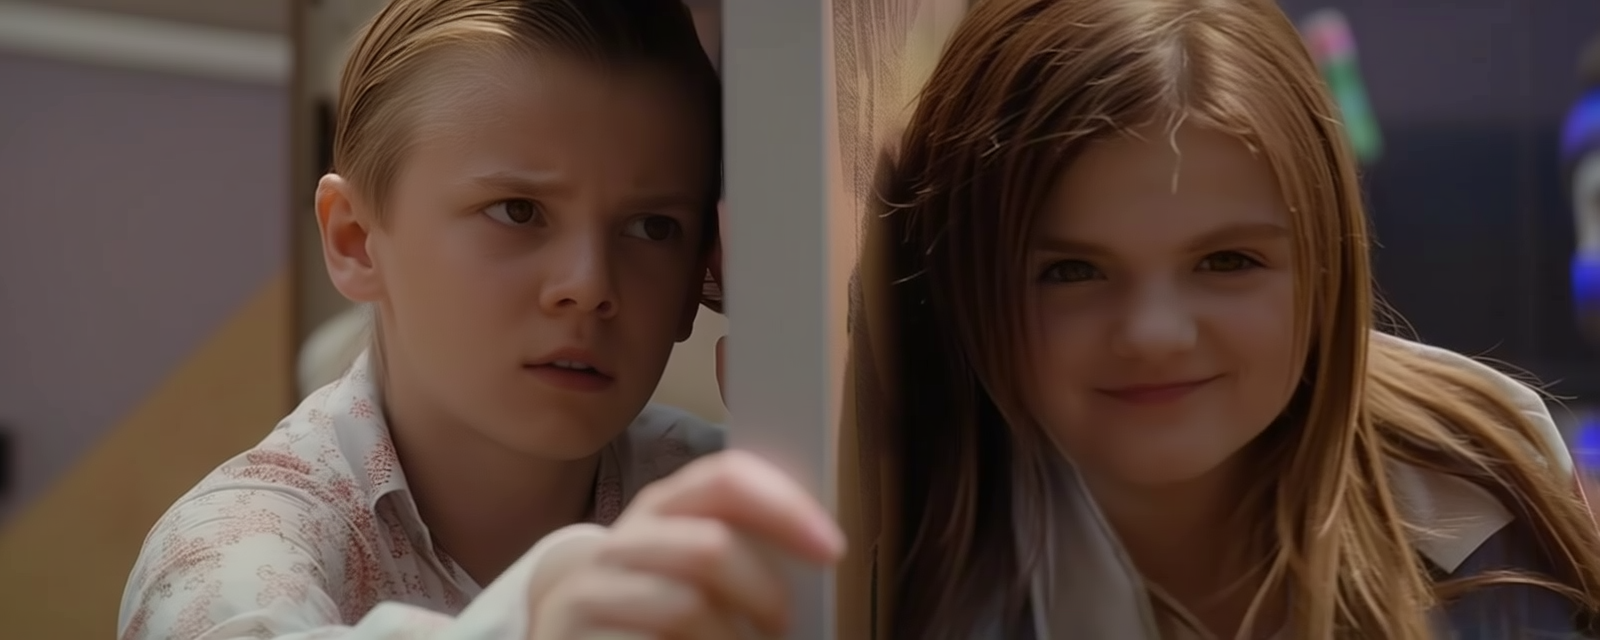

In [12]:
from musubi_tuner.utils.preproc_utils import postproc_imgs, get_text_preproc, get_all_control_kwargs
from musubi_tuner.frame_pack.k_diffusion_hunyuan import sample_hunyuan

# seed = np.random.randint(2**31)
seed = 1528632667
print(seed)

text_kwargs = get_text_preproc(prompt, 
    framepack_model.text_encoder1, framepack_model.text_encoder2, framepack_model.tokenizer1, framepack_model.tokenizer2, 
    entity_prompts=[], device=framepack_model.device)

control_kwargs, entity_masks, control_nps, debug_mask, print_res = get_all_control_kwargs(
    panel_layout, characters_shot, framepack_model.vae, width=width, height=height,
    crop_face_detect=True, use_rembg=True, 
    c_width_given=256, bbox_mode='provided_size_mid_x',
    control_indices=[0], latent_indices=[3], 
    max_chara_imgs=2, max_chara=5,
)
# print(print_res)
# control_kwargs['clean_latent_bboxes'] = torch.tensor([[[0.,0.,1.,1.]]]).repeat(1, control_kwargs['clean_latent_bboxes'].shape[1], 1)
entity_masks = None

generator = torch.Generator(device="cpu")
generator.manual_seed(seed)
total_kwargs = {
    'prompt': prompt, 'sampler': 'unipc', 'width': width, 'height': height, 'frames': 1, 'batch_size': 1,
    'num_inference_step': 25, 'generator': generator, 'device': framepack_model.device, 'dtype': framepack_model.dtype,
    'cache_results': False, 'cache_layers': [],
    'use_attention_masking': ['no_cross_control_latents', 'mask_control'],
    'entity_masks': entity_masks,
}
# attn_cache.clear()
results = sample_hunyuan(transformer=framepack_model.model, **total_kwargs, **text_kwargs, **control_kwargs,)

result_img = Image.fromarray(postproc_imgs(results[0:1], framepack_model.vae)[0])
result_img

# Image.fromarray(np.sum(entitymask_nps, axis=0)>0).convert("RGB")

  0%|          | 0/25 [00:00<?, ?it/s]

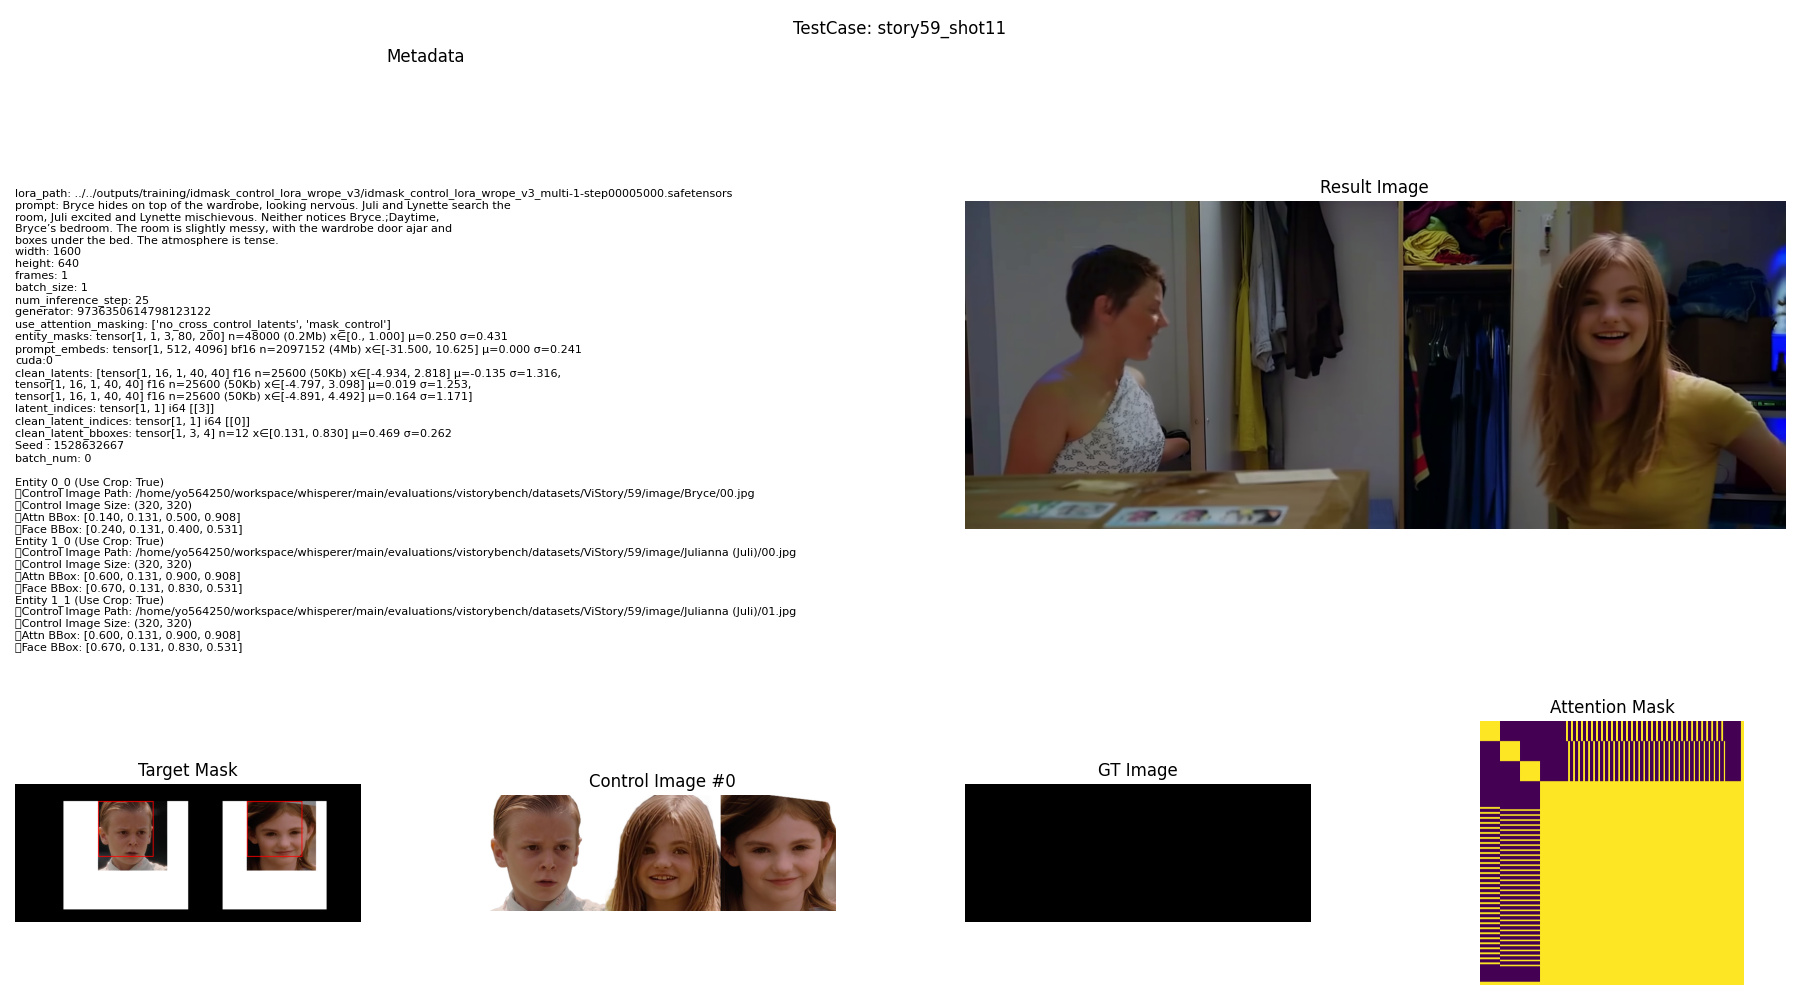

In [9]:
# seed = np.random.randint(2**31) #1174730479, 2085107311
seed = 1528632667

result_imgs, debug_imgs, debug_mask = framepack_model(
    prompt, panel_layout, characters_shot, width, height,
    c_width_given=256, seed=seed, crop_face_detect=True, use_rembg=True,
    cache_results=False, cache_layers=['transformer_blocks.2'], 
    use_attention_masking=['no_cross_control_latents', 'mask_control'], 
    control_indices=[0], latent_indices=[3], max_chara=5,
    debug_name=f"story{story_num}_shot{shot_num}"
)

# result_imgs[0].save(f"tmp/{story_num}/{shot_num-1}_0.png")
# debug_imgs[0].save(f"tmp/{story_num}/debug/{shot_num-1}_0.png")

debug_imgs[0]

In [ ]:
result_imgs[0]

In [ ]:
layout = {'[PANEL-1]': ([80, 69, 907, 379],
  {0: {'bbox': [0.011, 0.218, 0.705, 0.988], 'body': []}}),
 '[PANEL-2]': ([492, 394, 911, 674],
  {1: {'bbox': [0.027, 0.27, 0.988, 0.973], 'body':[]}}),
 '[PANEL-3]': ([82, 394, 482, 674],
  {0: {'bbox': [0.05, 0.1, 0.4, 0.968], 'body': []},
   1: {'bbox': [0.5, 0.1, 0.9, 0.968], 'body': []}}),
 '[PANEL-4]': ([524, 687, 909, 944],
  {0: {'bbox': [0.014, 0.118, 0.896, 0.898], 'body': []}}),
 '[PANEL-5]': ([82, 689, 516, 944],
  {0: {'bbox': [0.004, 0.114, 0.668, 0.986], 'body': []}})}

color_dict = {
    0 : {'outline' : "#F2AA84", 'fill' : "#F6C6AD"},
    1 : {'outline' : "#47D45A", 'fill' : "#84E291"},
    2 : {'outline' : "#4E95D9", 'fill' : '#A6CAEC'}
}
layout_w, layout_h = 768, 1024
layout_img = Image.new("RGB", (layout_w, layout_h), "WHITE")
layout_draw = ImageDraw.Draw(layout_img)

for panel_id, (panel_bbox, panel_layout) in layout.items():
    panel_bbox = [
        panel_bbox[0]/1000*layout_w, panel_bbox[1]/1000*layout_h,
        panel_bbox[2]/1000*layout_w, panel_bbox[3]/1000*layout_h,
    ]
    layout_draw.rectangle(panel_bbox, outline=(0,0,0), width=4)
    panel_layout = {
        i: [
            max(x['bbox'][0], 0.02)*(panel_bbox[2]-panel_bbox[0])+panel_bbox[0], max(x['bbox'][1], 0.02)*(panel_bbox[3]-panel_bbox[1])+panel_bbox[1],
            min(x['bbox'][2], 0.98)*(panel_bbox[2]-panel_bbox[0])+panel_bbox[0], min(x['bbox'][3], 0.98)*(panel_bbox[3]-panel_bbox[1])+panel_bbox[1],
        ]
        for i,x in panel_layout.items()}
    for i, body_bbox in panel_layout.items():
        # if panel_id in ['[PANEL-3]', '[PANEL-4]', '[PANEL-5]', '[PANEL-6]']:
        #     i = 2
        layout_draw.rectangle(body_bbox, outline=color_dict[i]['outline'], width=2, fill=color_dict[i]['fill'])

layout_img

In [ ]:
from musubi_tuner.utils.keypalign_utils import align_face
from musubi_tuner.utils.preproc_utils import rmbg14_session

control_image = Image.open('/groups/chenchen/patrick/ViStoryBench/dataset/ViStory/09/image/Snow White/00.jpg').convert("RGB")
control_image = align_face(control_image)
control_image = rmbg14_session(control_image)
control_image

In [ ]:
results_dict_temp = {}
for i in range(9):
    seed = np.random.randint(2**31)
    result_imgs, debug_imgs, debug_mask = framepack_model(
        prompt, panel_layout, characters_shot, width, height,
        c_width_given=256, seed=seed, crop_face_detect=True, use_rembg=True,
        cache_results=False, cache_layers=['transformer_blocks.2'], 
        use_attention_masking=['no_cross_control_latents', 'mask_control'], 
        control_indices=[0], latent_indices=[3], max_chara=5,
        debug_name=f"story{story_num}_shot{shot_num}"
    )

    results_dict_temp[i] = {
        'seed' : seed,
        'result_img': result_imgs[0], 'debug_img': debug_imgs[0],
        'debug_mask': debug_mask,
    }

fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i, (key, value) in enumerate(results_dict_temp.items()):
    ax[i // 3, i % 3].imshow(value['result_img'])
    ax[i // 3, i % 3].set_title(f"Seed {value['seed']}")
    ax[i // 3, i % 3].axis('off')
plt.tight_layout()
plt.show()

# results_dict_temp[8]['result_img'].save(Path("tmp") / f"{story_num}/{shot_num-1}_0.png")
# results_dict_temp[8]['debug_img'].save(Path("tmp") / f"{story_num}/debug/{shot_num-1}_0.png")

In [ ]:
results_dict_temp[4]['debug_img']

In [ ]:
outputs_root = Path("/groups/chenchen/patrick/ViStoryBench/outputs/")
story_num = 17
shutil.copytree(
    f"/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/practice/tmp/{story_num}", 
    outputs_root / f"whisperer/v3_3_step6000/en/20251028_232847_v2/{story_num}", 
    dirs_exist_ok=True
)
# shutil.copytree(
#     "/lustre/fs1/groups/chenchen/patrick/ViStoryBench/outputs/whisperer/v3_3_step6000/en/20251028_232847", 
#    "/lustre/fs1/groups/chenchen/patrick/ViStoryBench/outputs/whisperer/v3_3_step6000/en/20251028_232847_v2",
#     dirs_exist_ok=True
# )

In [ ]:
import time

trials = 10
trials_time = []

idx = 44
sample = dreambench_plus[idx // 9]
caption_ind = idx % 9
width, height = 1024, 1024

prompt = sample.captions[caption_ind]
c_width = 512
panel_layout = {0: {'bbox': [0.1, 0.1, 0.9, 0.9], 'body': []}}
characters_shot = {0 : {'images' : [sample.image_path]}}

for _ in range(trials):
    start_time = time.time()
    
    seed = np.random.randint(2**31)
    result_imgs, debug_imgs, debug_mask = framepack_model(
        prompt, panel_layout, characters_shot, width, height,
        c_width_given=c_width, seed=seed, crop_face_detect=False, use_rembg=False,
        cache_results=False, cache_layers=['transformer_blocks.2'], 
        use_attention_masking=['no_cross_control_latents'], 
        control_indices=[0], latent_indices=[3],
        debug_name=f"{sample.collection_id}-{caption_ind}"
    )

    end_time = time.time()
    trials_time.append(end_time - start_time)

print(f"Avg inference time over {trials} trials: {np.mean(trials_time):.2f} sec")